## 1. Imports and Fetch Dataset

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id1 = '1Bmmc5fTi6fy1MMFBkRG6o_eGLOMtjeWL'
downloaded = drive.CreateFile({'id': file_id1})
downloaded.GetContentFile('questions.csv')

## 2. Imports

In [3]:
! pip install contractions
! pip install nltk
! pip install fuzzywuzzy
! pip install python-Levenshtein

import nltk
import contractions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

nltk.download('all')

     |████████████████████████████████| 284 kB 8.7 MB/s 
     |████████████████████████████████| 321 kB 12.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85453 sha256=d8aa3af231ea815e46f4c1bbcf81ebc03e981ea622ada74e841f835568a0b21d
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 50 kB 3.7 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149870 sha256=bfa5d01e60710e7000dcd85ce8f0d9edd8886b1b6c0d31648fef42855524addf
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]   

True

## 3. EDA


In [4]:
questions = pd.read_csv('questions.csv')

In [5]:
questions.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
def handleNAN(df):
  print(df.isna().sum())
  df = df.dropna()
  print(df.isna().sum())
  return df

In [7]:
questions = handleNAN(questions)

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [8]:
def stats(df):
  size = len(df)
  print('Number of rows in dataset : {}'.format(size))

  isDuplicate = dict(df['is_duplicate'].value_counts(normalize=True))

  sns.set_theme(style="whitegrid")
  ax = sns.barplot(
        x=list(isDuplicate.keys()), 
        y=list(isDuplicate.values()), 
      )
  ax.set(xlabel="Class Labels", ylabel = "Ratio", title='Ratio of each class in Dataset')
  plt.show()
  zeros = (df == 0).sum(axis=0)['is_duplicate']
  print('{} or {:.3f} % of pairs are not-duplicate questions.'.format(zeros, isDuplicate[0]*100))
  print('{} or {:.3f} % of pairs are duplicate questions.'.format(size - zeros, isDuplicate[1]*100))

  qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
  uniqueQIds= len(np.unique(qids))
  qIdMoreThanOne = np.sum(qids.value_counts() > 1)
  # qIdFreq = dict(qids.value_counts())
  # qIdFreqSorted = dict(sorted(qIdFreq.items(), key=lambda item: item[1], reverse=True))

  print('Total Number of Unique Questions = {}'.format(uniqueQIds))
  print('Total Number of Repeated Questions = {}'.format(qIdMoreThanOne))

Number of rows in dataset : 404348


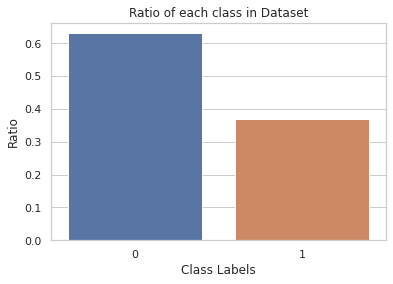

255042 or 63.075 % of pairs are not-duplicate questions.
149306 or 36.925 % of pairs are duplicate questions.
Total Number of Unique Questions = 789795
Total Number of Repeated Questions = 13698


In [9]:
stats(questions)

## 4. Preprocessing

In [10]:
def textPreprocessing(text):
  # Lower-casing whole text
  text = str(text).lower().strip()
  # Handling Clitics - 
  contractions.fix(text)
  # Removing digits - 
  text = ''.join(filter(lambda x: not x.isdigit(), text))
  # Handling currency symbols - 
  text = text.replace('%', ' percent')
  text = text.replace('$', ' dollar ')
  text = text.replace('₹', ' rupee ')
  text = text.replace('€', ' euro ')
  text = text.replace('@', ' at ')
  # Removing some characters - 
  text = re.sub('[!#%&\'()*+,-./:;?@[\]^_`{|}~]', '', text)
  # Removing Stopwords
  text = text.split(' ')
  text = [i for i in text if i not in stopwords]
  text = ' '.join([str(i) for i in text if i])
  text = text.strip()
  return text


def extractNouns(text):
  wordsList = text.split(' ')
  nouns = ''
  try:
    tagged = nltk.pos_tag(wordsList)
    for tag in tagged:
      if 'NN' in tag[1]:
        nouns += tag[0]
        nouns += ' '
  except:
    pass
  return nouns


def preprocess(df):
  df['question1'] = df['question1'].apply(textPreprocessing)
  df['question2'] = df['question2'].apply(textPreprocessing)
  df['question1_nouns'] = df['question1'].apply(extractNouns)
  df['question2_nouns'] = df['question2'].apply(extractNouns)
  return df

def getCommonWordsCount(row):
  w1 = set(row['question1'].split(' '))
  w2 = set(row['question2'].split(' '))
  w = w1.intersection(w2)
  return len(w)

def getUniqueWordsCount(row):
  w1 = set(row['question1'].split(' '))
  w2 = set(row['question2'].split(' '))
  w = w1.union(w2)
  return len(w)

def extractFeatures(df):
  df['q1_word_count'] = df['question1'].apply(lambda x: len(x.split()))
  df['q2_word_count'] = df['question2'].apply(lambda x: len(x.split()))
  df['q1len'] = df['question1'].str.len() 
  df['q2len'] = df['question2'].str.len()
  df['common_word_count'] = df.apply(getCommonWordsCount, axis=1)
  df['total_unique_word_count'] = df.apply(getUniqueWordsCount, axis=1)
  df['common_word_ratio'] = df['common_word_count'] / df['total_unique_word_count']
  df['total_word_count'] = df['q1_word_count'] + df['q2_word_count']
  df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x.question1, x.question2), axis=1)
  df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x.question1, x.question2), axis=1)
  df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x.question1, x.question2), axis=1)
  df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x.question1, x.question2), axis=1)

  return df

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
questions = preprocess(questions)

In [12]:
questions = extractFeatures(questions)

In [13]:
questions.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_nouns,question2_nouns,q1_word_count,q2_word_count,q1len,q2len,common_word_count,total_unique_word_count,common_word_ratio,total_word_count,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,step step share market india,step step share market,7,6,41,35,5,6,0.833333,13,92,100,100,92
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,story kohinoor kohinoor diamond,government kohinoor diamond,4,9,31,67,2,9,0.222222,13,59,94,84,59
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,increase speed connection vpn,speed dns,6,5,44,36,2,9,0.222222,11,55,56,70,70
3,3,7,8,mentally lonely solve,find remainder mathmath divided,0,,remainder mathmath,3,4,21,31,0,7,0.000000,7,27,29,27,27
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,dissolve water quikly sugar carbon di,fish salt water,10,5,60,29,2,13,0.153846,15,43,52,51,40


## EDA-II

In [14]:
def plotKDE(df, featureName, xlabel, title):
  ax = sns.kdeplot(df[featureName], hue=df['is_duplicate'])
  ax.set(xlabel=xlabel, ylabel = "Density", title=title)
  plt.show()

def visualise(df):
  plotKDE(df, 'common_word_ratio', 'Common Word Ratio', 'PDF of Common word Ratio')
  plotKDE(df, 'common_word_count', 'Common Word Count', 'PDF of Common word Count')
  plotKDE(df, 'fuzz_ratio', 'Fuzzy Ratio', 'PDF of Fuzzy ratio')
  plotKDE(df, 'fuzz_partial_ratio', 'Fuzzy partial ratio', 'PDF of Fuzzy partial ratio')
  plotKDE(df, 'fuzz_token_set_ratio', 'Fuzzy token set ratio', 'PDF of Fuzzy token set ratio')
  plotKDE(df, 'fuzz_token_sort_ratio', 'Fuzzy token sort ratio', 'PDF of Fuzzy token sort ratio')
  


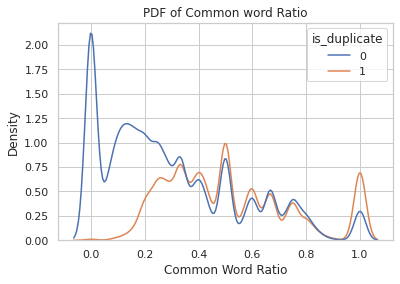

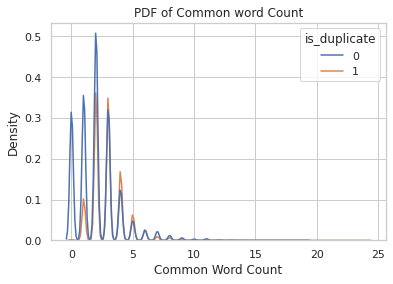

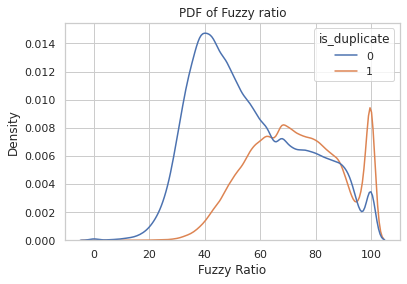

In [ ]:
visualise(questions)

In [16]:
questions.to_csv('train.csv', index=False)